In [1]:
from pathlib import Path 

from training_raster_clipper.core.models import TrainingConfiguration, TrainingFunctions 

from training_raster_clipper.core.logging import log_info

from training_raster_clipper.core.visualization import (
    plot_rgb_data_array,
    plot_array,
    plot_geodataframe,
)

from IPython.display import display

import matplotlib.pyplot as plt

from pathlib import Path

from rioxarray import open_rasterio
from geopandas import read_file
import geopandas as gpd
import numpy as np
import rioxarray
import xarray as xr
from affine import Affine
from geopandas.geodataframe import GeoDataFrame
from rasterio.features import rasterize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from training_raster_clipper.custom_types import (
    BandNameType,
    ClassificationResult,
    ClassifiedSamples,
    FeatureClassNameToId,
    PolygonMask,
    ResolutionType,
)


In [2]:
raster_input_path = Path("D:/Profils/rskandrani/Desktop/tutoriel S1/S2A_MSIL2A_20230823T104631_N0509_R051_T31TCJ_20230823T170355.SAFE")
polygons_input_path = Path("D:/Profils/rskandrani/Desktop/tutoriel S1/polygons_rf.geojson")

config = TrainingConfiguration(
    verbose = True,
    show_plots = True, 
    resolution = 60,
    band_names = ("B04", "B03", "B02", "B8A"),
    raster_input_path = raster_input_path,
    polygons_input_path = polygons_input_path,
    csv_output_path = (Path(".").resolve().parent / Path("generated/classified_points.csv")),
    raster_output_path=(Path(".").resolve().parent / Path("generated/sklearn_raster.tiff")),
    implementation_name="eschalk",
)
config


TrainingConfiguration(verbose=True, show_plots=True, resolution=60, band_names=('B04', 'B03', 'B02', 'B8A'), raster_input_path=WindowsPath('D:/Profils/rskandrani/Desktop/tutoriel S1/S2A_MSIL2A_20230823T104631_N0509_R051_T31TCJ_20230823T170355.SAFE'), polygons_input_path=WindowsPath('D:/Profils/rskandrani/Desktop/tutoriel S1/polygons_rf.geojson'), csv_output_path=WindowsPath('D:/Profils/rskandrani/Desktop/tutoriel S1/training-raster-clipper/generated/classified_points.csv'), raster_output_path=WindowsPath('D:/Profils/rskandrani/Desktop/tutoriel S1/training-raster-clipper/generated/sklearn_raster.tiff'), implementation_name='eschalk')

In [3]:
verbose = config.verbose
show_plots = config.show_plots

resolution = config.resolution
band_names = config.band_names

raster_input_path = config.raster_input_path
polygons_input_path = config.polygons_input_path
csv_output_path = config.csv_output_path
raster_output_path = config.raster_output_path


### (1) Load a GeoJSON file with `geopandas`

In [4]:
def load_feature_polygons(input_path: Path) -> GeoDataFrame:
    geodf = read_file(input_path)
    return GeoDataFrame(geodf).to_crs(32631)

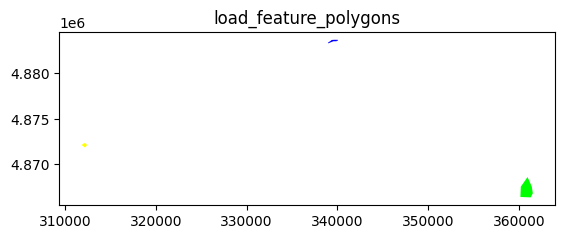

In [5]:
polygons = load_feature_polygons(polygons_input_path)
if verbose:
    log_info(polygons, "polygons")
if show_plots:
    plot_geodataframe(polygons, f"{load_feature_polygons.__name__}")


### (2) Load a Sentinel-2 raster with `rioxarray`

In [6]:
def load_sentinel_data(
    sentinel_product_location: Path,
    resolution: ResolutionType,
    band_names: tuple[BandNameType, ...],
) -> xr.DataArray:
    """Loads sentinel product

    Example input path: `S2A_MSIL2A_20221116T105321_N0400_R051_T31TCJ_20221116T170958.SAFE`

    Args:
        sentinel_product_location (Path): Location of the .SAFE folder containing a Sentinel-2 product.

    Returns:
        xr.DataArray: A DataArray containing the 3 RGB bands from the visible spectrum
    """
    RADIO_ADD_OFFSET = -1000
    QUANTIFICATION_VALUE = 10000

    dict_bands = {}
    if len(band_names) == 0:
        return print("no bands selected")
    for band in band_names:
        dict_bands[band] = sorted(
            Path(sentinel_product_location).glob(
                f"GRANULE/*/IMG_DATA/R{resolution}m/*_{band}_*"
            )
        )[0]

    list_dataarray = []

    for band_name, raster_path in dict_bands.items():
        raster = open_rasterio(raster_path)

        list_dataarray.append(raster.assign_coords({"band": [band_name]}))

    rasters_concat = xr.concat(list_dataarray, dim="band")

    result = rasters_concat.where(
        rasters_concat != 0,
        np.float32(np.NaN),
    )

    result = (result + RADIO_ADD_OFFSET) / QUANTIFICATION_VALUE

    return result


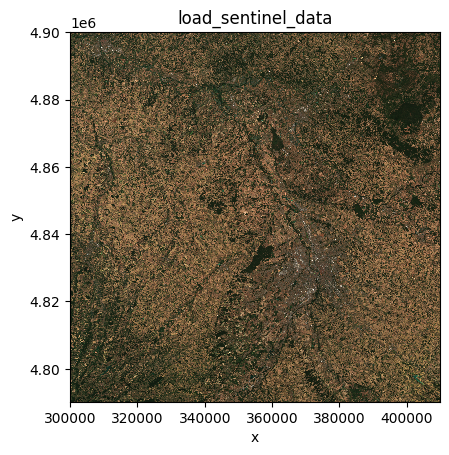

In [7]:
rasters = load_sentinel_data(raster_input_path, resolution, band_names)
if verbose:
    log_info(rasters, "rasters")
if show_plots:
    plot_rgb_data_array(rasters, f"{load_sentinel_data.__name__}")


In [8]:
rasters.rio.crs

CRS.from_epsg(32631)

In [9]:
list(reversed(rasters.shape[:2]))

[1830, 4]

In [10]:
display(polygons)

,id,class,color,geometry
0,NaN,WATER,#0000FF,"MULTIPOLYGON (((339030.792 4883385.946, 339383..."
1,NaN,FOREST,#00FF00,"MULTIPOLYGON (((361276.571 4866342.746, 360143..."
2,NaN,FARMLAND,#FFFF00,"MULTIPOLYGON (((311932.570 4872183.524, 312116..."


In [11]:
polygons.shape

(3, 4)

In [12]:
# rasters.spatial_ref.GeoTransform.split(' ')

# transform_tuple = (float(x) for x in rasters.spatial_ref.GeoTransform.split(' ') )
# tuple(transform_tuple)

### (3) Rasterize the polygons

In [13]:
def rasterize_geojson(
    data_array: xr.DataArray,
    training_classes: GeoDataFrame,
) -> tuple[PolygonMask, FeatureClassNameToId]:
    """Burns a set of vectorial polygons to a raster.

    See https://gis.stackexchange.com/questions/316626/rasterio-features-rasterize

    Args:
        data_array (xr.DataArray): The Sentinel raster, from which data is taken, such as the transform or the shape.
        training_classes (GeoDataFrame): The input set of classified multipolygons to burn

    Returns:
        xr.DataArray: A mask raster generated from the polygons, representing the same geographical region as the source dataarray param
                      0 where no polygon were found, and integers representing classes in order of occurence in the GeoDataFrame
    """

    transform_tuple = tuple(float(x) for x in data_array.spatial_ref.GeoTransform.split(' '))
    fwd = Affine.from_gdal(*transform_tuple)

    shape = data_array.isel(band=0).shape

    dict_mapping_class = dict(zip(training_classes.color,training_classes.index+1))

    geodf_list=list(zip(training_classes.geometry,training_classes.index+1))
    
    polygon_mask = rasterize(geodf_list, out_shape = shape, transform = fwd )

    return polygon_mask, dict_mapping_class

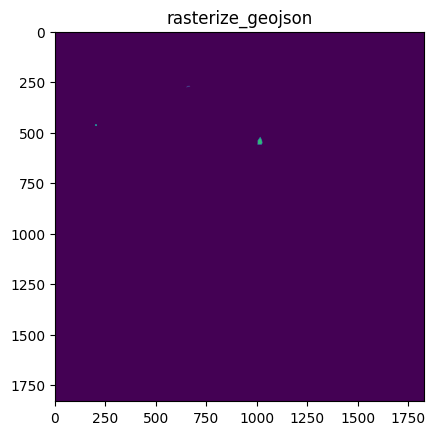

In [14]:
burnt_polygons, mapping = rasterize_geojson(rasters, polygons)
if verbose:
    log_info(burnt_polygons, "burnt_polygons")
    log_info(mapping, "mapping")
if show_plots:
    plot_array(burnt_polygons, f"{rasterize_geojson.__name__}")

In [15]:
burnt_polygons

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

### (4) Intersect the Sentinel-2 raster with polygons

In [16]:
def produce_clips(
    data_array: xr.DataArray, burnt_polygons: PolygonMask, mapping: FeatureClassNameToId
) -> ClassifiedSamples:
    """Extract RGB values covered by classified polygons

    Args:
        data_array (xr.DataArray): RGB raster
        burnt_polygons (PolygonMask): Rasterized classified multipolygons

    Returns:
        _type_: A list of the RGB values contained in the data_array and their corresponding classes
    """
    polygons_data_array = data_array.isel(band = 0).copy(data = burnt_polygons)

    dict_data_array_stacked = {'class' : polygons_data_array.stack(z=('y','x')), 'reflectance' : data_array.stack(z=('y','x'))}

    classified_reflectances = xr.Dataset(dict_data_array_stacked)
    class_not_zero = classified_reflectances['class'] != 0
    classified_reflectances = classified_reflectances.isel(z=class_not_zero)
    
    return classified_reflectances


In [17]:
classified_rgb_rows = produce_clips(rasters, burnt_polygons, mapping)
if verbose:
    log_info(classified_rgb_rows, "classified_rgb_rows")


In [18]:
classified_rgb_rows.drop_vars(['x','y','spatial_ref'])

C:\Users\rskandrani\AppData\Local\Temp\ipykernel_15264\4027989449.py:1: DeprecationWarning: Deleting a single level of a MultiIndex is deprecated. Previously, this deleted all levels of a MultiIndex. Please also drop the following variables: {'z'} to avoid an error in the future.
  classified_rgb_rows.drop_vars(['x','y','spatial_ref'])


<xarray.Dataset>
Dimensions:      (band: 4, z: 678)
Coordinates:
  * band         (band) <U3 'B04' 'B03' 'B02' 'B8A'
Dimensions without coordinates: z
Data variables:
    class        (z) uint8 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 2 2 2 2 2
    reflectance  (band, z) float32 0.0285 0.0292 0.0296 ... 0.3174 0.2996 0.3125

### (5) Persist the intersection to a CSV

In [19]:
def persist_to_csv(
    classified_rgb_rows: ClassifiedSamples,
    csv_output_path: Path,
) -> None:
    df_classified_rgb_rows = classified_rgb_rows.to_dataframe().to_csv('classified_rgb_rows.csv')

In [20]:
persist_to_csv(classified_rgb_rows, csv_output_path)
log_info(f"Written CSV output {csv_output_path}")


In [21]:
classified_rgb_rows['reflectance'].values

array([[0.0285, 0.0292, 0.0296, ..., 0.0661, 0.0596, 0.0554],
       [0.0497, 0.051 , 0.0517, ..., 0.0623, 0.0572, 0.0585],
       [0.0317, 0.0329, 0.0323, ..., 0.0394, 0.0354, 0.0349],
       [0.0316, 0.0285, 0.0276, ..., 0.3174, 0.2996, 0.3125]],
      dtype=float32)

In [22]:
rasters.stack(z=('y','x')).values

array([[0.089 , 0.0689, 0.0445, ..., 0.1026, 0.0906, 0.0898],
       [0.0986, 0.0868, 0.0595, ..., 0.0896, 0.0837, 0.0835],
       [0.0599, 0.051 , 0.035 , ..., 0.0552, 0.0501, 0.0497],
       [0.2927, 0.3433, 0.4003, ..., 0.3292, 0.3383, 0.3467]],
      dtype=float32)

In [23]:
classified_rgb_rows['class'].values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

### (6) Train a machine learning model

In [24]:
def classify_sentinel_data(
    rasters: xr.DataArray, classified_rgb_rows: ClassifiedSamples
) -> ClassificationResult:
    
    X_train = classified_rgb_rows['reflectance'].values
    y_train = classified_rgb_rows['class'].values

    model_rf = RandomForestClassifier().fit(X_train.T,y_train)

    predict_classes = model_rf.predict(rasters.stack(z=('y','x')).values.T)

    ref_raster = rasters.isel(band=0,drop=True)

    predict_classes_xarray = ref_raster.copy(data = np.reshape(predict_classes, ref_raster.shape))

    return predict_classes_xarray
    

In [25]:
mapping

{'#0000FF': 1, '#00FF00': 2, '#FFFF00': 3}

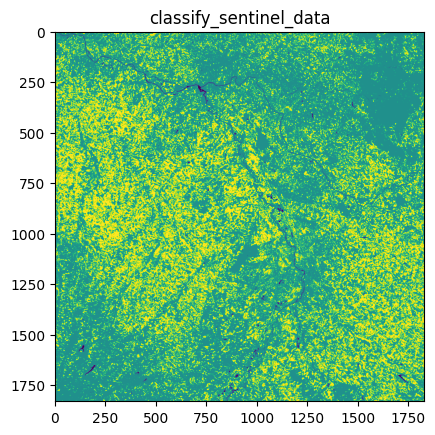

In [26]:
classification_result = classify_sentinel_data(
    rasters, classified_rgb_rows
)
if verbose:
    log_info(classification_result, "classification_result")
if show_plots:
    plot_array(
        classification_result, f"{classify_sentinel_data.__name__}"
    )

### (7) Export the classification raster result

In [29]:
def persist_classification_to_raster(
    raster_output_path: Path, classification_result: ClassificationResult
) -> None:
    classification_result.rio.to_raster(raster_output_path)


In [30]:
persist_classification_to_raster(
    raster_output_path, classification_result
)
log_info(f"Written Classified Raster to {csv_output_path}")

# --

log_info("Congratulations, you reached the end of the tutorial!")
